Mounted at /content/drive


/tmp/ipython-input-464646046.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cyclone_df['ISO_TIME'] = pd.to_datetime(cyclone_df['ISO_TIME'], errors='coerce')
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
http

ALERT SENT: 🌀 Cyclone Risk High on 2024-05-24 — Probability: 0.82
ALERT SENT: 🌀 Cyclone Risk High on 2024-05-25 — Probability: 0.84
ALERT SENT: 🌀 Cyclone Risk High on 2024-05-26 — Probability: 0.73
ALERT SENT: 🌀 Cyclone Risk High on 2024-05-27 — Probability: 0.85
ALERT SENT: 🌀 Cyclone Risk High on 2024-05-28 — Probability: 0.78
ALERT SENT: ⚠️ Flood Risk High on 2024-06-09 — Probability: 0.72
ALERT SENT: ⚠️ Flood Risk High on 2024-06-11 — Probability: 0.92
ALERT SENT: ⚠️ Flood Risk High on 2024-06-12 — Probability: 0.94
ALERT SENT: ⚠️ Flood Risk High on 2024-06-13 — Probability: 0.91
ALERT SENT: ⚠️ Flood Risk High on 2024-06-14 — Probability: 0.90
ALERT SENT: ⚠️ Flood Risk High on 2024-07-08 — Probability: 0.98
ALERT SENT: ⚠️ Flood Risk High on 2024-07-09 — Probability: 1.00
ALERT SENT: ⚠️ Flood Risk High on 2024-07-10 — Probability: 0.97
ALERT SENT: ⚠️ Flood Risk High on 2024-07-13 — Probability: 0.93
ALERT SENT: ⚠️ Flood Risk High on 2024-07-14 — Probability: 1.00
ALERT SENT: ⚠️ Flood

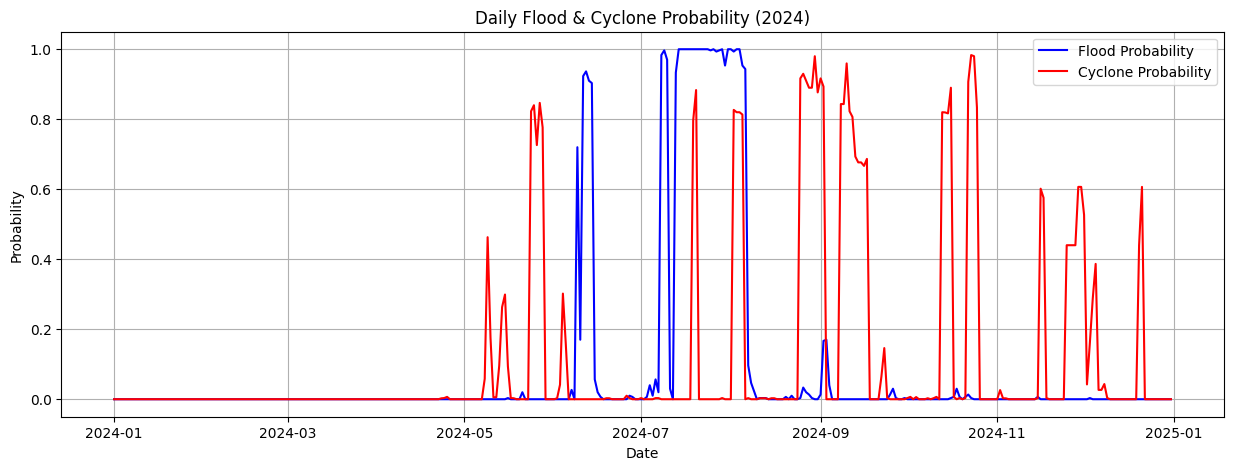

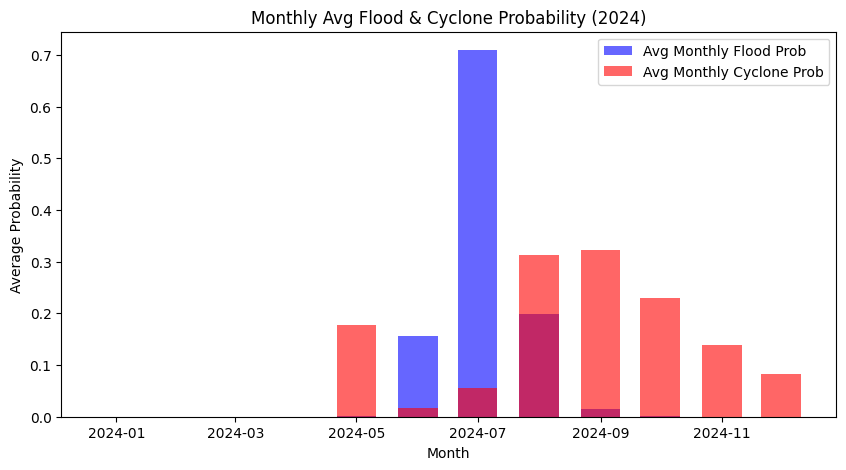

All done! Daily and monthly predictions ready, plots generated.

=== MODEL ACCURACIES ===
Flood Prediction Accuracy: 1.0
Cyclone Prediction Accuracy: 0.9562841530054644


In [ ]:
#PREDICTION AND ALERTS(ntfy)

# Install required packages
!pip install pandas numpy scikit-learn imbalanced-learn joblib matplotlib requests

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import requests

# NTFY SETTINGS
NTFY_TOPIC = "your-topic-here"   #replace with your subscribed topic in ntfy app
NTFY_URL = f"https://ntfy.sh/{NTFY_TOPIC}"

def send_alert(message):
    """Send push notification via ntfy"""
    try:
        requests.post(NTFY_URL, data=message.encode())
        print("ALERT SENT:", message)
    except:
        print("Error sending alert")

# Paths to data and models
rain_csv = '/content/drive/MyDrive/Disaster_Prediction_Project/data/KA_daily_2024.csv'
cyclone_csv = '/content/drive/MyDrive/Disaster_Prediction_Project/data/ibtracs.NI.list.v04r01.csv'

flood_model_path = '/content/drive/MyDrive/Disaster_Prediction_Project/models/rf_flood_all_years.joblib'
cyclone_model_path = '/content/drive/MyDrive/Disaster_Prediction_Project/models/rf_cyclone_all_years.joblib'

output_folder = '/content/drive/MyDrive/Disaster_Prediction_Project/outputs'
os.makedirs(output_folder, exist_ok=True)

# Load rainfall and cyclone data
df = pd.read_csv(rain_csv, parse_dates=['Date'])
cyclone_df = pd.read_csv(cyclone_csv, usecols=['ISO_TIME','LAT','LON','WMO_WIND','WMO_PRES'], low_memory=False)

# Feature engineering for flood model
df = df.sort_values('Date')
df['rain'] = df['Rainfall_mm']
df['rain3d'] = df['rain'].rolling(3, min_periods=1).sum()
df['rain7d'] = df['rain'].rolling(7, min_periods=1).sum()
df['rain10d'] = df['rain'].rolling(10, min_periods=1).sum()
df['doy'] = df['Date'].dt.dayofyear
df['month'] = df['Date'].dt.month

# Feature engineering for cyclone model
cyclone_df['ISO_TIME'] = pd.to_datetime(cyclone_df['ISO_TIME'], errors='coerce')
cyclone_df['WMO_WIND'] = pd.to_numeric(cyclone_df['WMO_WIND'], errors='coerce').fillna(0)
cyclone_df['WMO_PRES'] = pd.to_numeric(cyclone_df['WMO_PRES'], errors='coerce').fillna(1013)

# Aggregate max wind/pressure per day
wind_pressure = cyclone_df.groupby(cyclone_df['ISO_TIME'].dt.date)[['WMO_WIND','WMO_PRES']].max()
wind_pressure = wind_pressure.rename(columns={'WMO_WIND':'wind','WMO_PRES':'pressure'})

df['wind'] = df['Date'].dt.date.map(wind_pressure['wind']).fillna(0)
df['pressure'] = df['Date'].dt.date.map(wind_pressure['pressure']).fillna(1013)

# Create cyclone flag
cyclone_dates = cyclone_df['ISO_TIME'].dt.date.unique()
df['cyclone_flag'] = df['Date'].dt.date.isin(cyclone_dates).astype(int)

# Load pretrained models
rf_flood = joblib.load(flood_model_path)
rf_cyclone = joblib.load(cyclone_model_path)

# Prepare feature sets
flood_features = ['rain','rain3d','rain7d','rain10d','doy','month']
cyclone_features = ['Rainfall_mm','rain3d','rain7d','rain10d','wind','pressure']

# Make predictions
df['Flood_Prob'] = rf_flood.predict_proba(df[flood_features].fillna(0).values)[:,1]
df['Cyclone_Prob'] = rf_cyclone.predict_proba(df[cyclone_features].fillna(0).values)[:,1]


# ALERT LOGIC
for i, row in df.iterrows():
    date_str = str(row['Date'].date())

    if row['Flood_Prob'] > 0.7:
        send_alert(f"⚠️ Flood Risk High on {date_str} — Probability: {row['Flood_Prob']:.2f}")

    if row['Cyclone_Prob'] > 0.7:
        send_alert(f"🌀 Cyclone Risk High on {date_str} — Probability: {row['Cyclone_Prob']:.2f}")

# Save daily predictions
daily_out = os.path.join(output_folder, 'KA_daily_predictions_2024.csv')
df.to_csv(daily_out, index=False)
print("Daily predictions saved to:", daily_out)

# Monthly aggregation
monthly = df.groupby(df['Date'].dt.to_period('M')).agg({
    'Rainfall_mm':'sum',
    'Flood_Prob':'mean',
    'Cyclone_Prob':'mean',
    'cyclone_flag':'sum'
}).reset_index()
monthly['Date'] = monthly['Date'].dt.to_timestamp()

monthly_out = os.path.join(output_folder, 'KA_monthly_predictions_2024.csv')
monthly.to_csv(monthly_out, index=False)
print("Monthly predictions saved to:", monthly_out)

# PLOTS
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df['Flood_Prob'], label='Flood Probability', color='blue')
plt.plot(df['Date'], df['Cyclone_Prob'], label='Cyclone Probability', color='red')
plt.title('Daily Flood & Cyclone Probability (2024)')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.bar(monthly['Date'], monthly['Flood_Prob'], width=20, alpha=0.6, label='Avg Monthly Flood Prob', color='blue')
plt.bar(monthly['Date'], monthly['Cyclone_Prob'], width=20, alpha=0.6, label='Avg Monthly Cyclone Prob', color='red')
plt.title('Monthly Avg Flood & Cyclone Probability (2024)')
plt.xlabel('Month')
plt.ylabel('Average Probability')
plt.legend()
plt.show()

print("All done! Daily and monthly predictions ready, plots generated.")

# ACCURACY CALCULATION

# Flood prediction (threshold 0.5)
df['Flood_Pred'] = (df['Flood_Prob'] >= 0.5).astype(int)

# Cyclone prediction (threshold 0.5)
df['Cyclone_Pred'] = (df['Cyclone_Prob'] >= 0.5).astype(int)

flood_accuracy = accuracy_score(df['flooded'] if 'flooded' in df.columns else df['Flood_Pred'], df['Flood_Pred'])
cyclone_accuracy = accuracy_score(df['cyclone_flag'], df['Cyclone_Pred'])

print("\n=== MODEL ACCURACIES ===")
print("Flood Prediction Accuracy:", flood_accuracy)
print("Cyclone Prediction Accuracy:", cyclone_accuracy)

In [2]:
# GRADIO DASHBOARD
!pip install gradio plotly pandas

import gradio as gr
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# LOAD CSV FILES
output_folder = '/content/drive/MyDrive/Disaster_Prediction_Project/outputs'
year = 2024
daily_csv = os.path.join(output_folder, f'KA_daily_predictions_{year}.csv')
monthly_csv = os.path.join(output_folder, f'KA_monthly_predictions_{year}.csv')

df = pd.read_csv(daily_csv, parse_dates=['Date'])
monthly = pd.read_csv(monthly_csv, parse_dates=['Date'])

# Remove time from Date
df['Date'] = df['Date'].dt.date
monthly['Date'] = monthly['Date'].dt.date

# DASHBOARD FUNCTION
def dashboard():

    today = datetime.today().date()
    this_week = [today + timedelta(days=i) for i in range(7)]

    # TODAY + WEEKLY RISK
    flood_today = df[df['Date'] == today]['Flood_Prob']
    cyclone_today = df[df['Date'] == today]['Cyclone_Prob']

    flood_today = flood_today.values[0] if len(flood_today) else 0
    cyclone_today = cyclone_today.values[0] if len(cyclone_today) else 0

    flood_week = df[df['Date'].isin(this_week)]['Flood_Prob'].max()
    cyclone_week = df[df['Date'].isin(this_week)]['Cyclone_Prob'].max()

    # Alert Logic
    alert = ""

    if flood_today > 0.7:
        alert += f"🚨 **Flood risk TODAY: {flood_today:.2f}**\n\n"
    elif flood_week > 0.7:
        alert += f"⚠️ Flood risk THIS WEEK: {flood_week:.2f}.\n\n"
    else:
        alert += "🟢 No significant flood risk this week.\n\n"

    if cyclone_today > 0.7:
        alert += f"🌀 **Cyclone risk TODAY: {cyclone_today:.2f}**\n\n"
    elif cyclone_week > 0.7:
        alert += f"⚠️ Cyclone risk THIS WEEK: {cyclone_week:.2f}.\n\n"
    else:
        alert += "🟢 No significant cyclone risk this week.\n\n"

    # DAILY PLOT
    df['Flood_Color'] = df['Flood_Prob'].apply(lambda x: 'red' if x > 0.7 else 'blue')
    df['Cyclone_Color'] = df['Cyclone_Prob'].apply(lambda x: 'red' if x > 0.7 else 'green')

    fig_daily = go.Figure()
    fig_daily.add_trace(go.Scatter(
        x=df['Date'], y=df['Flood_Prob'],
        mode='lines+markers',
        name='Flood',
        marker=dict(color=df['Flood_Color'])
    ))
    fig_daily.add_trace(go.Scatter(
        x=df['Date'], y=df['Cyclone_Prob'],
        mode='lines+markers',
        name='Cyclone',
        marker=dict(color=df['Cyclone_Color'])
    ))
    fig_daily.update_layout(title="Daily Flood & Cyclone Probabilities",
                            yaxis=dict(range=[0,1]))

    # MONTHLY BAR CHART
    fig_month = px.bar(
        monthly, x='Date', y=['Flood_Prob','Cyclone_Prob'],
        barmode='group',
        title="Monthly Average Probabilities"
    )
    fig_month.update_layout(yaxis=dict(range=[0,1]))

    # RISK CALENDAR (MONTH-GRID VIEW)
    df_calendar = df.copy()
    df_calendar['Flood_Risk'] = df_calendar['Flood_Prob'].apply(lambda x: 'High' if x>0.7 else 'Low')
    df_calendar['Cyclone_Risk'] = df_calendar['Cyclone_Prob'].apply(lambda x: 'High' if x>0.7 else 'Low')

    df_calendar['Risk'] = df_calendar.apply(
        lambda row: 'High' if row['Flood_Risk']=='High' or row['Cyclone_Risk']=='High' else 'Low',
        axis=1
    )

    # Add month and day columns for grid plotting
    df_calendar['Month'] = pd.to_datetime(df_calendar['Date']).dt.month_name()
    df_calendar['Day'] = pd.to_datetime(df_calendar['Date']).dt.day

    fig_calendar = px.scatter(
        df_calendar, x='Day', y='Month', color='Risk',
        color_discrete_map={'High':'red','Low':'green'},
        title="High-Risk Days Calendar (Month View)",
        labels={'Day':'Day of Month', 'Month':'Month'}
    )
    fig_calendar.update_yaxes(categoryorder='array',
                              categoryarray=[
                                  'January','February','March','April','May','June',
                                  'July','August','September','October','November','December'
                              ])

    return (alert, fig_daily, fig_month, fig_calendar)

# GRADIO UI
with gr.Blocks() as demo:

    gr.Markdown("<h1 style='text-align:center;'>🌧 Karnataka Flood & Cyclone Dashboard (2024)</h1>")

    alert_box = gr.Markdown()
    daily_plot = gr.Plot()
    month_plot = gr.Plot()
    calendar_plot = gr.Plot()

    demo.load(fn=dashboard,
              inputs=[],
              outputs=[alert_box, daily_plot, month_plot, calendar_plot])

demo.launch(share=True)

Mounted at /content/drive
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://da1339fa7e7ae9c46e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
